In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from models.quantization import Quantization
import matplotlib.pyplot as plt
from torch.nn.utils.parametrize import register_parametrization as rpm
from tqdm.notebook import tqdm
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2


In [48]:
class QuantizedWeights(nn.Module):
    """
    Parametrization of the weights of a layer with quantization

    Args:
        mask (torch.tensor): mask for the weights
    """

    def __init__(self, quant):
        super().__init__()
        self.quant = quant

    def forward(self, W):
        return self.quant(W)


class Net(nn.Module):
    def __init__(self, quantization=False):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(28 * 28, 128, bias=False)
        self.fc2 = nn.Linear(128, 10, bias=False)
        self.dropout1 = nn.Dropout(0.1)

        if quantization:
            self.quant_values = [-4, -2, -1, 0, 1, 2, 4]
            # self.quant_biases = np.zeros(len(self.quant_values) - 1)
            self.quant_biases = np.linspace(
                self.fc1.weight.data.min(),
                self.fc1.weight.data.max(),
                len(self.quant_values) - 1,
            )
            self.quant = Quantization(
                quant_values=self.quant_values,
                quan_bias=self.quant_biases,
                init_beta=1,
                device="cpu",
            )
            # rpm(self.conv1, "weight", QuantizedWeights(self.quant))
            # rpm(self.conv2, "weight", QuantizedWeights(self.quant))
            rpm(self.fc1, "weight", QuantizedWeights(self.quant))
            rpm(self.fc2, "weight", QuantizedWeights(self.quant))


    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        # x  = self.dropout1(x)
        x = F.relu(x)
        # x = self.dropout1(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [26]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if  use_cuda else "cpu")

In [37]:
model = Net(quantization=True)

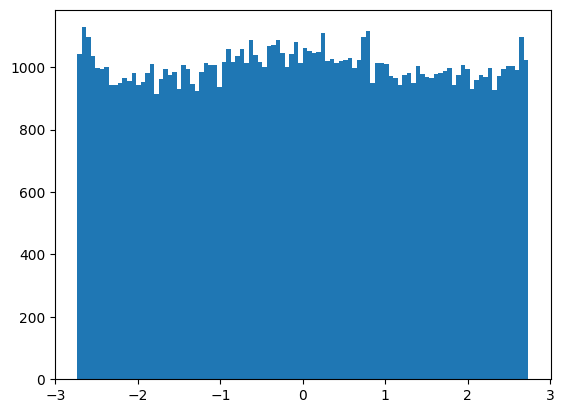

In [43]:
if hasattr(model, "quant") : 
    model.quant.training = True
    model.quant.T = 100
plt.hist(model.fc1.weight.cpu().detach().numpy().flatten(), bins=100);
# model.quant.training = False
# plt.hist(model.fc1.weight.detach().numpy().flatten(), bins=100);

In [45]:
def train(model, device, train_loader, optimizer, epoch, pbar=None):
    model.train()
    if hasattr(model, "quant"):
        model.quant.training = True
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if hasattr(model, "quant"):
            model.quant.T += 1

        desc = str(
            "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch,
                batch_idx * len(data),
                len(train_loader.dataset),
                100.0 * batch_idx / len(train_loader),
                loss.item(),
            )
        )

        if pbar is not None:
            pbar.set_description(desc)
    
def test(model, device, test_loader, pbar=None):
    model.eval()
    if hasattr(model, "quant"):
        model.quant.training = False
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    desc = str(
        "| Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

    if pbar is not None:
        pbar.set_description(desc)

    return test_loss, correct / len(test_loader.dataset), desc

In [46]:
batch_size = 64
test_batch_size = 1000

train_kwargs = {"batch_size": batch_size}
test_kwargs = {"batch_size": test_batch_size}
if use_cuda:
    cuda_kwargs = {"num_workers": 1, "pin_memory": True, "shuffle": True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)
dataset1 = datasets.MNIST("../data", train=True, download=True, transform=transform)
dataset2 = datasets.MNIST("../data", train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)


model = Net(quantization=True).to(device)
if hasattr(model, "quant") :
    model.quant.training = True
    model.quant.T = 100
lr = 1e-3
gamma = 0.95
optimizer = optim.Adam(model.parameters(), lr=lr)

n_epochs = 30

In [47]:
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
pbar = tqdm(range(1, n_epochs + 1))
for epoch in pbar:
    train(model, device, train_loader, optimizer, epoch, pbar=None)
    test(model, device, test_loader, pbar=pbar)
    scheduler.step()


  0%|          | 0/30 [00:00<?, ?it/s]

In [21]:
test(model, device, test_loader, pbar=pbar)


(3.6413160400390625,
 0.1136,
 '| Test set: Average loss: 3.6413, Accuracy: 1136/10000 (11%)\n')

In [10]:
next(iter(train_loader))[0].shape

torch.Size([64, 1, 28, 28])

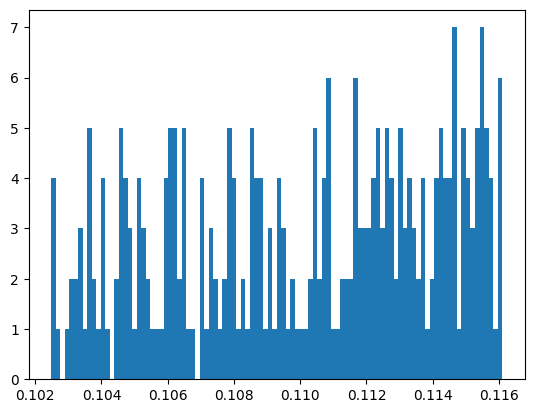

In [38]:
model.quant.training = True
plt.hist(model.conv1.weight.cpu().detach().numpy().flatten(), bins=100);


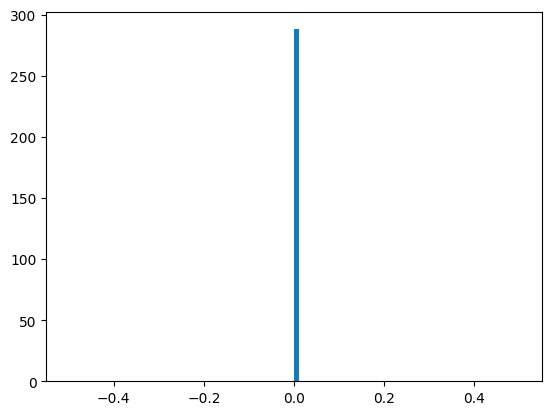

In [39]:
model.quant.training = False
plt.hist(model.conv1.weight.cpu().detach().numpy().flatten(), bins=100);

In [35]:
for m, n in model.named_parameters():
    if hasattr(n, "weight"):
        plt.hist(n.weight.detach().cpu().numpy().flatten(), bins=100)